<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> May 23, 2020 (Monday). 23:00
</div>

# Exercise 11.2. Generative adversarial networks (GANs). WGAN-GP: Wasserstein GAN with gradient penalty

The goal of this exercise is to get familiar with WGAN-GP: one of the most popular versions of GANs, which is relatively easy to train.

The algorithm was introduced in the paper [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf).

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torchvision.utils as utils

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
device = torch.device('cuda:0')
#device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Wasserstein GAN (WGAN)

The WGAN value function is constructed as
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
where
* the dicriminator $D$ (called critic in WGAN) is constrained to be from the set $\mathcal{D}$ of 1-Lipschitz functions
* $P_r$ is the data distribution
* $P_g$ is the model distribution. Samples from the model distribution are produced as follows:
\begin{align}
z &\sim N(0, I)
\\
\tilde x &= G(z)
\end{align}

## Generator

Implement the generator in the cell below. We recommend you to use the same architecture of the generator as in Exercise 11.1.

In [8]:
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """GAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        super(Generator, self).__init__()
        # YOUR CODE HERE
        self.c1 = nn.Sequential(
            nn.ConvTranspose2d(nz, 4 * ngf, 4, stride=2, padding=0),
            nn.BatchNorm2d(4 * ngf),
            nn.ReLU(True),
        )
        self.c2 = nn.Sequential(
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(2 * ngf),
            nn.ReLU(True)
        )
        self.c3 = nn.Sequential(
            nn.ConvTranspose2d(2 * ngf, ngf, 4, stride=2, padding=2),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        self.c4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
                          so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        # YOUR CODE HERE
        a = z
        a = self.c1(a)
        if verbose:
            print(a.shape)
        a = self.c2(a)
        if verbose:
            print(a.shape)
        a = self.c3(a)
        if verbose:
            print(a.shape)
        a = self.c4(a)
        if verbose:
            print(a.shape)
        return a

In [9]:
def test_Generator_shapes():
    batch_size = 32
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Generator_shapes()

torch.Size([32, 256, 4, 4])
torch.Size([32, 128, 8, 8])
torch.Size([32, 64, 14, 14])
torch.Size([32, 1, 28, 28])
Success


### Loss for training the generator

The generator is trained to minimize the relevant part of the value function using a fixed critic $D$:
$$
  \min_G − E_{\tilde{x} \sim P_g}[D( \tilde x)]
$$

In [17]:
def generator_loss(D, fake_images):
    """Loss computed to train the WGAN generator.

    Args:
      D: The critic whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      loss: The relevant part of the WGAN value function.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    d = D(fake_images)
    return -d.log().mean()

tests.test_generator_loss(generator_loss)

loss: tensor(1.0730)
expected: tensor(1.0730)
Success


In [11]:
# This cell tests generator_loss()

## Critic

In WGAN, the discriminator is called a critic because it is not trained to classify.

Implement the WGAN critic in the cell below. You can use almost the same architecture as the architecture of the discriminator in Exercise 11.1. The difference is that there is no need to use `sigmoid` nonlinearity in the output layer because the output of the critic does not have to be between 0 and 1.

In [18]:
class Critic(nn.Module):
    def __init__(self, nc=1, ndf=64):
        """
        Args:
          nc:  Number of channels in the images.
          ndf: Base size (number of channels) of the critic layers.
        """
        # YOUR CODE HERE
        super(Critic, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(ndf, 2 * ndf, 4, stride=2, padding=2),
            nn.LeakyReLU(0.2),
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(2 * ndf, 4 * ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(4 * ndf, nc, 4, stride=2, padding=0),
#             nn.Sigmoid(),
        )

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be evaluated.
        
        Returns:
          out of shape (batch_size,): Critic outputs for images x.
        """
        # YOUR CODE HERE
        x = self.c1(x)
        if verbose:
            print(x.shape)
        x = self.c2(x)
        if verbose:
            print(x.shape)
        x = self.c3(x)
        if verbose:
            print(x.shape)
        x = self.c4(x)
        if verbose:
            print(x.shape)
        return x.squeeze()

In [19]:
def test_Critic_shapes():
    nz = 10  # size of the latent z vector
    netD = Critic(nc=1, ndf=64)

    batch_size = 32
    images = torch.ones(batch_size, 1, 28, 28)
    out = netD(images, verbose=True)
    assert out.shape == torch.Size([batch_size]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Critic_shapes()

torch.Size([32, 64, 14, 14])
torch.Size([32, 128, 8, 8])
torch.Size([32, 256, 4, 4])
torch.Size([32, 1, 1, 1])
Success


### Loss for training the WGAN critic

Recall the value function of WGAN:
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
To tune the critic, we need to minimize the following function:
$$
  \min_{D \in \mathcal{D}} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
$$
You need to implement this loss function *assuming no constraints on D* in the function below.

In [25]:
def critic_loss(critic, real_images, fake_images):
    """
    Args:
      critic: The critic.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images.

    Returns:
      loss (scalar tensor): Loss for training the WGAN critic.
    """
    # YOUR CODE HERE
    d_real = critic(real_images)
    d_fake = critic(fake_images)
    return d_fake.mean() - d_real.mean()

def test_critic_loss():
    netD = Critic(nc=1, ndf=64)
    real_images = fake_images = torch.ones(32, 1, 28, 28)

    loss = critic_loss(netD, real_images, fake_images)
    assert loss.shape == torch.Size([]), "d_loss_real should be a scalar tensor."
    print('Success')

test_critic_loss()

Success


In [26]:
# This cell tests critic_loss()

Without constraints on $D$, the WGAN value function can be made infinitely large. WGAN constrains the derivative of $D$ using a gradient penalty. The penalty is computed at random points between real images and generated ones using the following procedure:
* Given a real image $x$ and a fake image $\tilde x$, draw a random number $\epsilon \sim U[0,1]$
* $\hat{x} \leftarrow \epsilon x + (1−\epsilon) \tilde x$
* Compute the gradient penalty $(‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2$
where $\nabla_{\hat{x}} D(\hat{x})$ is the gradient of $D$ computed at $\hat{x}$.

Your task is to implement the gradient penalty in the cell below. Note that we need to compute the gradient $\nabla D$ so that we can differentiate through the gradient when computing the derivatives wrt the parameters of the critic. This can be achieved by using function [torch.autograd.grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad) which can create a computational graph with the gradient computations.

In [93]:
def gradient_penalty(critic, real, fake_detached):
    """
    Args:
      critic: The critic.
      real of shape (batch_size, nc, 28, 28): Real images.
      fake_detached of shape (batch_size, nc, 28, 28): Fake images (detached from the computational graph).

    Returns:
      grad_penalty (scalar tensor): Gradient penalty.
      x of shape (batch_size, nc, 28, 28): Points x-hat in which the gradient penalty is computed.
    """
    # YOUR CODE HERE
    critic.to(real.device)
    rand = torch.rand(real.shape, device=real.device)
    x_hat = rand * real + (1 - rand) * fake_detached
    x_hat = torch.autograd.Variable(x_hat, requires_grad=True)
    x_hat.requires_grad = True
    xx = critic(x_hat)
    grad = torch.autograd.grad(xx, x_hat, grad_outputs=torch.ones(xx.shape, device=real.device), create_graph=True, retain_graph=True, only_inputs=True)[0]
    penalty = ((grad.norm(2) - 1) ** 2).mean()
    return penalty, x_hat

In [94]:
tests.test_gradient_penalty(gradient_penalty)

loss: tensor(729., grad_fn=<MeanBackward0>)
expected: tensor(729.)
Success


# Training WGAN-GP

We will now train WGAN-GP. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [87]:
from scorer import Scorer
scorer = Scorer()
scorer.to(device)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


Scorer(
  (model): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (relu1): ReLU()
      (drop1): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (relu2): ReLU()
      (drop2): Dropout(p=0.2, inplace=False)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [88]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=128, nc=1).to(device)
netD = Critic(nc=1, ndf=128).to(device)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the critic:    Adam with learning rate 0.0001
* Optimizer of the generator: Adam with learning rate 0.0001
* Weight $\lambda=10$ of the gradient penalty term in the discriminator loss:
$$
  \min_{D} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
  + \lambda (‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2
$$

Hints:
- We will use the scorer defined above to assess the quality of the generated samples. The desired level of 0.66 should be reached within 15-20 epochs.
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [0, 1].
```
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)
```
- The quality of the images is slightly worse than with the DCGAN.

epoch: 0
Loss: -41.238434


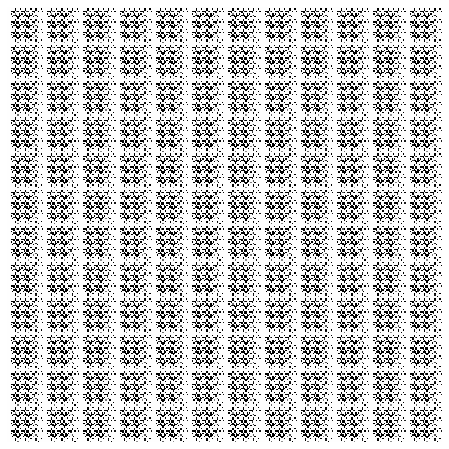

Score: 0.995302
epoch: 1
Loss: -57.872185


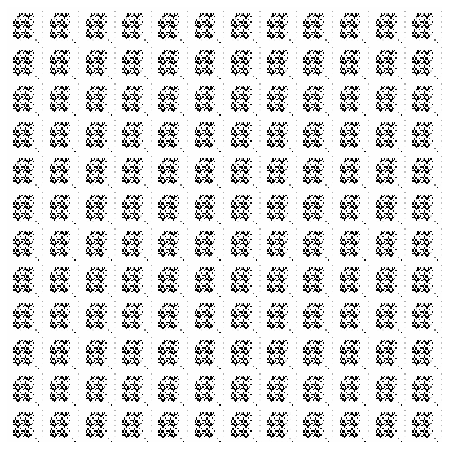

Score: 1.056468
epoch: 2
Loss: -78.055550


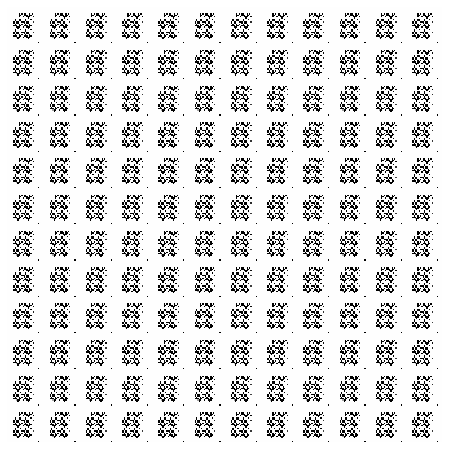

Score: 1.041507
epoch: 3
Loss: -96.323044


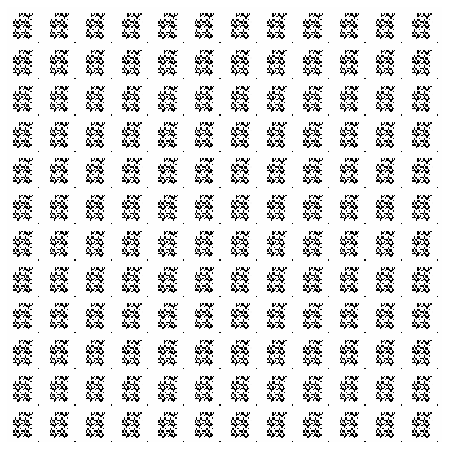

Score: 1.046502
epoch: 4
Loss: -102.949387


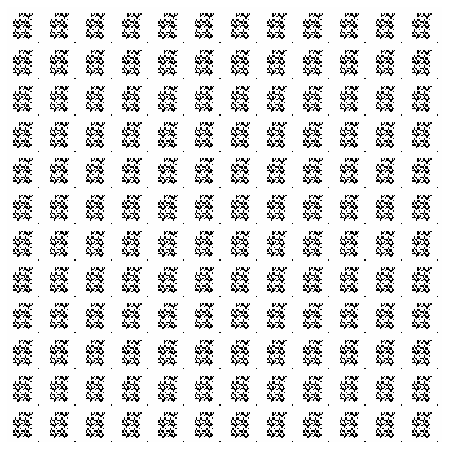

Score: 1.041201
epoch: 5
Loss: -115.377617


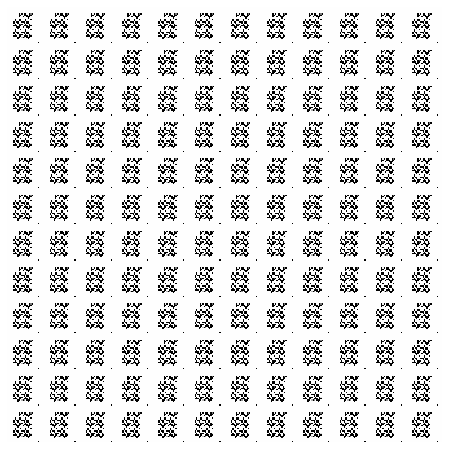

Score: 1.036500
epoch: 6
Loss: -123.395706


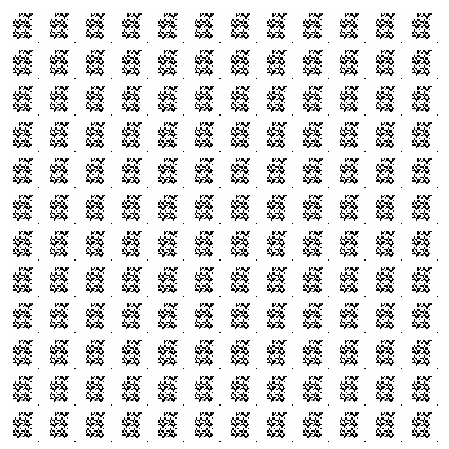

Score: 1.034278
epoch: 7
Loss: -122.839333


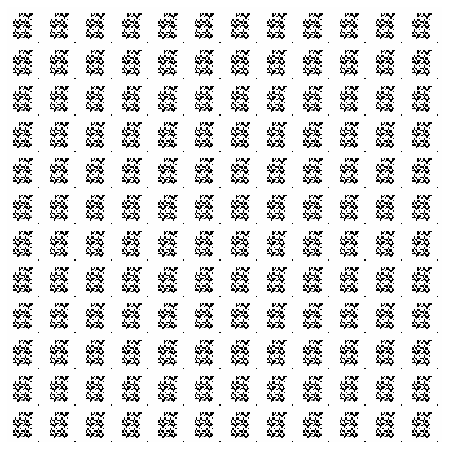

Score: 1.035812
epoch: 8
Loss: -144.665894


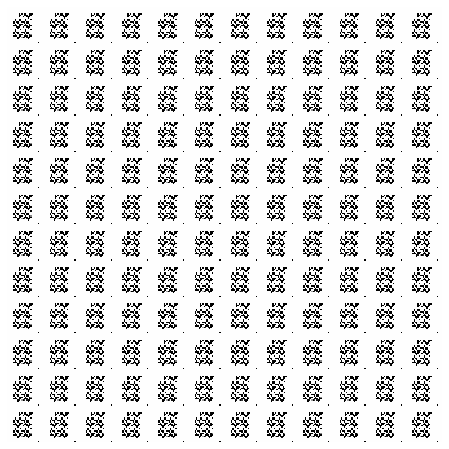

Score: 1.038433
epoch: 9
Loss: -154.262390


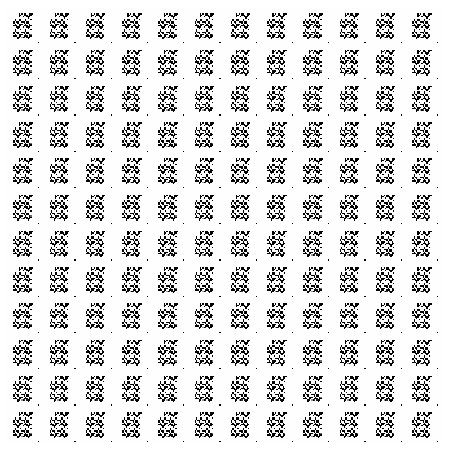

Score: 1.040098
epoch: 10
Loss: -146.118591


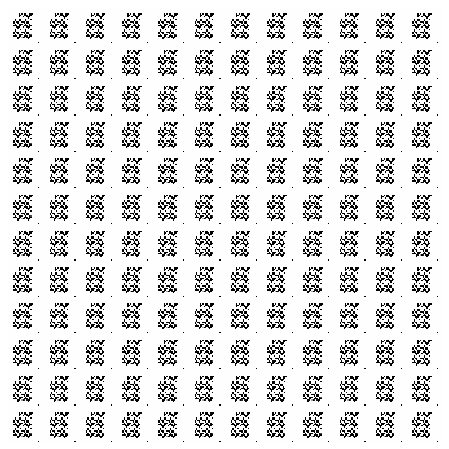

Score: 1.042354
epoch: 11
Loss: -158.397842


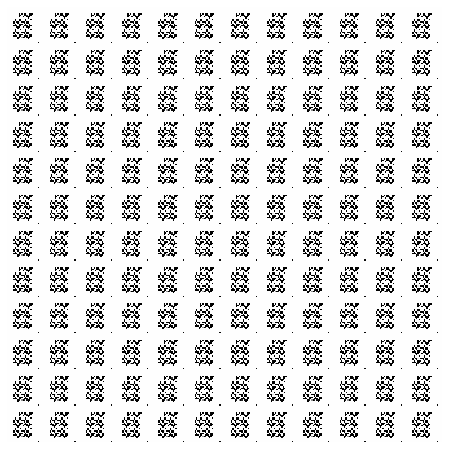

Score: 1.045217
epoch: 12
Loss: -186.355865


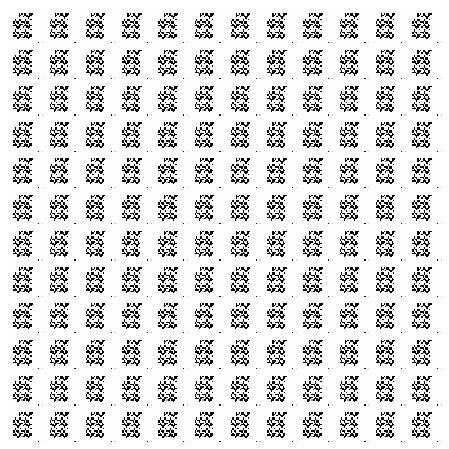

Score: 1.045756
epoch: 13
Loss: -167.561707


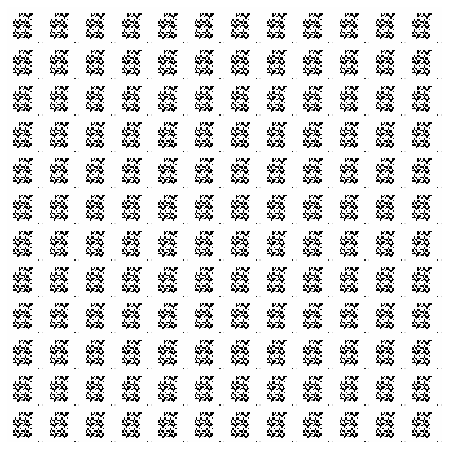

Score: 1.046385
epoch: 14
Loss: -168.517044


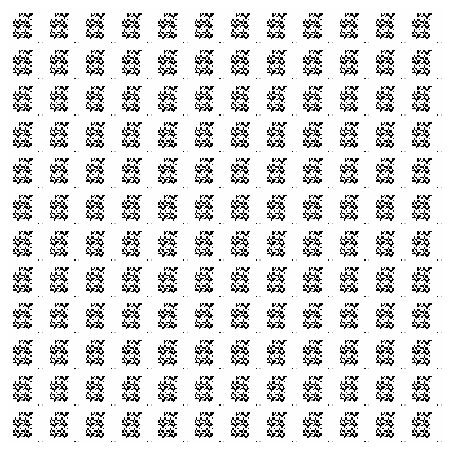

Score: 1.045331
epoch: 15
Loss: -192.008972


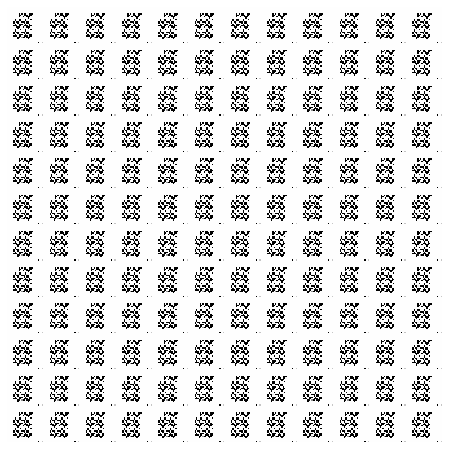

Score: 1.045112
epoch: 16
Loss: -179.965195


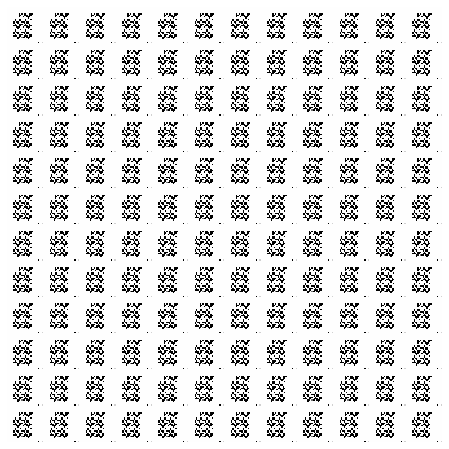

Score: 1.045466
epoch: 17
Loss: -177.272858


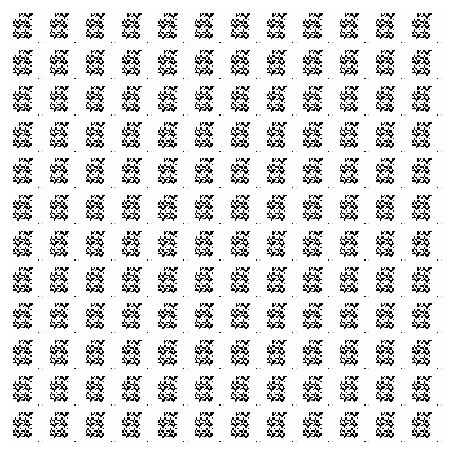

Score: 1.045714
epoch: 18
Loss: -161.703354


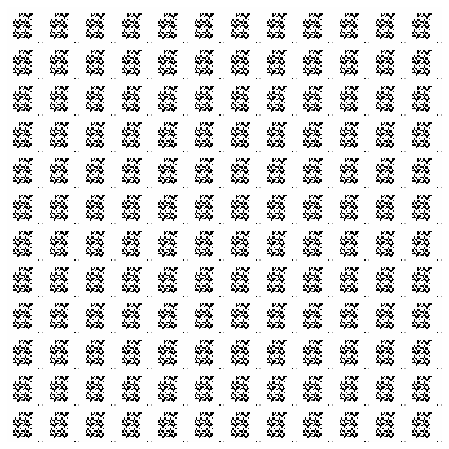

Score: 1.045347
epoch: 19
Loss: -192.523865


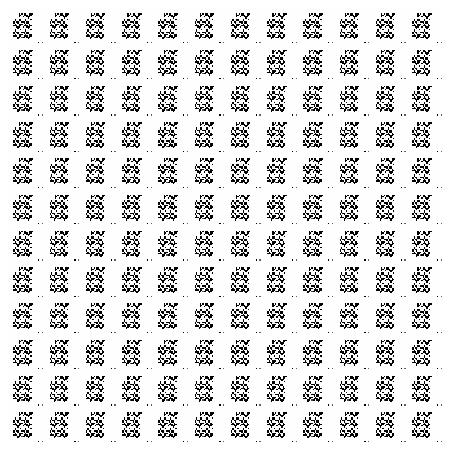

Score: 1.044438


In [96]:
if not skip_training:
    # YOUR CODE HERE
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(.5, .999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(.5, .999))
    criterion = nn.BCELoss()
    for i in range(20):
        print("epoch: %d" % i)
        for i_batch, data in enumerate(trainloader):
            data = data[0]
            netD.zero_grad()
            netG.zero_grad()
            data = data.to(device)
            b_size = data.shape[0]
            noise = torch.randn(b_size, nz, 1, 1, device=device)

            fake = netG(noise)
            loss = critic_loss(netD, data, fake.detach()) + 10 * gradient_penalty(netD, data, fake.detach())[0]
            loss.backward()
            optimizerD.step()
            
            g_loss = generator_loss(netD, fake)
            g_loss.backward()
            optimizerG.step()
        print("Loss: %f" % (loss))
        with torch.no_grad():
            # Plot generated images
            z = torch.randn(144, nz, 1, 1, device=device)
            samples = netG(z)
            tools.plot_generated_samples(samples)

            # Compute score
            z = torch.randn(1000, nz, 1, 1, device=device)
            samples = netG(z)
            samples = (samples + 1) / 2  # Re-normalize to [0, 1]
            score = scorer(samples)
            print('Score: %f' % score)

In [97]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(netG, '11_wgan_g.pth')
    tools.save_model(netD, '11_wgan_d.pth')
else:
    nz = 10
    netG = Generator(nz=nz, ngf=128, nc=1)
    netD = Critic(nc=1, ndf=128)
    
    tools.load_model(netG, '11_wgan_g.pth', device)
    tools.load_model(netD, '11_wgan_d.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 11_wgan_g.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 11_wgan_d.pth.


In [98]:
# Evaluate generated samples
with torch.no_grad():
    z = torch.randn(2000, nz, 1, 1, device=device)
    samples = (netG(z) + 1) / 2
    score = scorer(samples)

print(f'The trained WGAN-GP achieves a score of {score:.5f}')
assert score >= 0.66, "Poor GAN score! Check your architecture and training."
print('Success')

The trained WGAN-GP achieves a score of 1.04444
Success
